This Notebook was built with the purpose of understanding how to compute gradients and optimization routines with Graph Nets library. The compatibility between keras, tensorflow and Graph Nets is not fully supported. There are some grey areas which make all the standard implementation fails. Specifically, it is needed among other things to use the Adam optimizer of the Sonnet module. This was only discovered thanks to the notebook from the demo of graph nets 2 (the only example compatible with tensorflow2) called sort.py at the link:
Minor adjustment in the source code are needed to run the notebook sort.ipynb. 
The pipeline for this notebook was: 
0) Understanding how the custom gradient implementation of tensorflow behaves
1) taking the most naive version from the implementation of the main code
2) Comparing step by step the sort.ipynb notebook with the structure needed for our work
3) Finding out how to compute gradients (None values were ubiquitos initially)
4) subsequently understanding how to apply the optimizer to this naive version 
5) Increasing the complexity in order to implement IT-SWO 
    Point 5 can be subsequently divided in subtasks:
        5.1)
        5.2)
        5.3)


## Step 0: 
Of course there are plenty of other examples, this is just a representative one for comparison.


In [2]:
import tensorflow as tf
@tf.custom_gradient
def custom_relu2(x):
    def relu_grad(dy):
        grad=  tf.cast( x > 0, dtype=tf.float32)*dy
        return grad
    return tf.maximum(x, 0.), relu_grad
data = tf.Variable([0.5, -0.2, 0.0, -2.5, 3.0], dtype=tf.float32)


2024-06-08 09:38:43.452470: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 09:38:43.644990: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 09:38:44.323190: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 09:38:46.384125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-08 09:38:50.588412: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-08 09:38:50.589135: W tensorflow/co

In [3]:
import tensorflow as tf

@tf.custom_gradient
def custom_relu(x):
    def relu_forward(x):
        return tf.maximum(x, 0)
    
    def relu_grad(dy):
        grad = tf.cast(x > 0, dtype=tf.float32) * dy
        return grad

    return relu_forward(x), relu_grad

# Define a trainable variable
w = tf.Variable([1.0], dtype=tf.float32)  # A simple weight variable

# Define an input
x = tf.constant([1.0, -1.0, -2.0, 2.0, 3.0], dtype=tf.float32)

# Define an optimizer
optimizer = tf.optimizers.SGD(learning_rate=0.01)

for step in range(3):
    with tf.GradientTape() as tape:
        y = custom_relu(w * x)  # Apply ReLU to a linear transformation of x
        print(y, type(y))
        # Compute gradients of y with respect to w
        gradients = tape.gradient(y, w)
        print(gradients)
        # Apply gradients to update w
        optimizer.apply_gradients(zip([gradients], [w]))

        print("Updated w:", w.numpy())



tf.Tensor([1. 0. 0. 2. 3.], shape=(5,), dtype=float32) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([6.], shape=(1,), dtype=float32)
Updated w: [0.94]
tf.Tensor([0.94 0.   0.   1.88 2.82], shape=(5,), dtype=float32) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([6.], shape=(1,), dtype=float32)
Updated w: [0.88]
tf.Tensor([0.88      0.        0.        1.76      2.6399999], shape=(5,), dtype=float32) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([6.], shape=(1,), dtype=float32)
Updated w: [0.82]


## Step 1 




In [4]:
import tensorflow as tf
import sonnet as snt
from graph_nets import modules

hidden_layer_size=4   #This will be 128
output_emb_size=4      #This has to be 64 at the end
# Define the MLP model
class MLPModel_glob(snt.Module):
    def __init__(self, name=None):
        super(MLPModel_glob, self).__init__(name=name)
        self.layer1 = snt.Linear(output_size=hidden_layer_size, name='Glob_layer')
       

    def __call__(self, inputs):
        out = tf.nn.relu(self.layer1(inputs))
        
        return out
class MLPModel_4layers(snt.Module):
    def __init__(self, name=None):
        super(MLPModel_4layers, self).__init__(name=name)
        self.layer1 = snt.Linear(output_size=hidden_layer_size, name='enc_layer')
        

    def __call__(self, inputs):
        out = tf.nn.relu(self.layer1(inputs))

        return out

# Define the Encoder layer
class Encoder(modules.GraphNetwork):
    def __init__(self):
        super(Encoder, self).__init__(
            edge_model_fn=MLPModel_4layers,
            node_model_fn=MLPModel_4layers,
            global_model_fn=MLPModel_glob
        )

    def __call__(self, inputs):
        return super(Encoder, self).__call__(inputs)

    
class MLPModel_dec(snt.Module):
    def __init__(self, name=None):
        super(MLPModel_dec, self).__init__(name=name)
        self.layer1 = snt.Linear(output_size=hidden_layer_size, name='dec_layer')

    def __call__(self, inputs):
        out = tf.nn.relu(self.layer1(inputs))

        return out

class Decoder(modules.GraphNetwork):
    def __init__(self):
        super(Decoder, self).__init__(
            edge_model_fn=MLPModel_dec,
            node_model_fn=MLPModel_dec,
            global_model_fn=MLPModel_glob
        )

    def __call__(self, inputs):
        return super(Decoder, self).__call__(inputs)    
class PoolingLayer_double(tf.Module):
    def __init__(self):
        super(PoolingLayer_double, self).__init__()
        self.linear = snt.Linear(output_size=2, name='linear_pool')
        self.global_transform = snt.Linear(output_size=2, name='global_transform')

    def __call__(self, inputs):
        # Sum-pooling over nodes and edges
        pooled_nodes = tf.reduce_sum(inputs.nodes, axis=0)
        pooled_edges = tf.reduce_sum(inputs.edges, axis=0)
        pooled_features = tf.concat([pooled_nodes, pooled_edges], axis=0)
        
        transformed = self.linear(tf.expand_dims(pooled_features, axis=0))
        
        # Transform globals to match the shape of transformed
        transformed_globals = self.global_transform(0.05 *inputs.globals)
        #### THIS IS THE MOST RELEVANT PART, why again I can not use elu here? Is something related to the metric as well
        out = tf.nn.elu(transformed + transformed_globals)
        
        return out    
class simple_gnn(snt.Module):
    def __init__(self):
        super(simple_gnn, self).__init__()
        self.encoder = Encoder()
        self.pooling_layer = PoolingLayer_double()

    def __call__(self, inputs):
        encoded = self.encoder(inputs)

        output = self.pooling_layer(encoded)
        return output

In [5]:
import numpy as np
import time
import networkx as nx
from graph_nets import utils_np, utils_tf
from compgraph.useful import node_to_index
# Set a random seed
start=time.time()
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define the lattice size
lattice_size = (2,2)
#Batch size, the number of graphs that will be computed simultaneously by the GNN
batch_size= 4

# Create a square lattice
G = nx.grid_2d_graph(*lattice_size, periodic=True)
# Number of sites
num_sites = lattice_size[0] * lattice_size[1]

# Relabel the nodes to use integers
mapping = node_to_index(G)

G = nx.relabel_nodes(G, mapping)
# Initialize the sublattice encoding
sublattice_encoding = np.zeros((num_sites, 2))  # Two sublattices
sublattice_encoding[::2, 0] = 1  # Sublattice 1
sublattice_encoding[1::2, 1] = 1  # Sublattice 2
# Create a dictionary where the keys are the node indices and the values are dictionaries
# containing the 'features' field and the corresponding sublattice encoding
node_dict = {i: {"features": sublattice_encoding[i]} for i in range(num_sites)}
# Use the dictionary to set the node attributes in the graph
#nx.set_node_attributes(G, node_dict)
# Add 'features' to nodes
for node in G.nodes():
    G.nodes[node]['features'] = sublattice_encoding[node]
# Add 'features' to edges
# Add 'features' to edges
for edge in G.edges():
    u, v = edge
    G.edges[u, v]['features'] = [1.0]  # Replace with your actual edge features
    G.edges[v, u]['features'] = [1.0]  # Add undirected edge # Replace with your actual edge features
# Now convert the networkx graph to a GraphsTuple
graph_tuple = utils_np.networkxs_to_graphs_tuple([G])

# Number of configurations to generate
n_configs = 6
n_graph=n_configs*batch_size
# Generate the basis configurations
basis_configs = np.random.randint(2, size=(n_graph, num_sites)) * 2 - 1  # Random spins (-1 or 1)

# Concatenate the basis configurations and the sublattice encoding to form the node features
node_features = np.concatenate([basis_configs[:, :, np.newaxis], np.repeat(sublattice_encoding[np.newaxis, :, :], len(basis_configs), axis=0)], axis=2)

# Get the edge indices
edge_index = np.array(G.edges()).T
edge_index_duplicated = np.concatenate([edge_index, edge_index[::-1]], axis=1)
bias_value=0.5
# Create a list of graph dicts
graph_tuples = []
for i in range(n_graph):
    graph_dict = {
        'globals': np.array([0.05]),
        'nodes': node_features[i],
        'edges': np.full((edge_index_duplicated.shape[1], 1), bias_value),
        'senders': edge_index_duplicated[0],
        'receivers': edge_index_duplicated[1]
    }
    
    # Convert to a GraphsTuple and append to the list
    graph_tuples.append(utils_tf.data_dicts_to_graphs_tuple([graph_dict]))


print("end time:", time.time()-start)

end time: 0.1259305477142334


/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [6]:
from useful import create_graph_tuples, compare_graph_tuples
graph_tuples2=create_graph_tuples(basis_configs,G,sublattice_encoding)


# Usage:
result = compare_graph_tuples(graph_tuples2, graph_tuples)
print("Graphs are equal:", result)

Graphs are equal: True


In [7]:
# Instantiate the model
simple_gnn = simple_gnn()
for i in range(1):
    a,b =simple_gnn(graph_tuples[i])[0]
    print(a,b)

tf.Tensor(1.8513225677819865, shape=(), dtype=float64) tf.Tensor(1.0092861107726787, shape=(), dtype=float64)


In [8]:
def mock_loss_function(amplitude, phase):
    """A mock loss function for illustration purposes h"""
    return tf.abs(1- phase*amplitude**2)


## Step 2 to 4
Most of the work here was done by trial and error and a lot of print statements among other strategies. 
The end result looks decently clean but the hidden work behind was quite intensive.
Observations: sonnet modules seems to not be compatible with keras optimizers built on tensorflow. We need to use the sonnet optimizers.
Furthermore, the sonnet optimizer does not allow for a learning schedule with Exponential decay as was intended to be used initially. 
The only useful implementation is of the standard Adam optimization routine. (Trivial SGD is inadequate for so many parameters, ca va sans dire)
No fancy version of Adam are available, maybe it is for the best though.

In [9]:
#import sonnet as snt
#initial_learning_rate = 7e-3
#decay_steps = 8 * 1e5
#decay_rate = 0.1
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate, decay_steps, decay_rate, staircase=True)
#print(lr_schedule)
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, clipnorm=1)


In [10]:
initial_learning_rate = 7e-3
optimizer = snt.optimizers.Adam(initial_learning_rate,0.9)

def train_step(model, input_graph, optimizer):

    with tf.GradientTape() as tape:
        output = model(input_graph)[0]

        tape.watch(model.trainable_variables)
        print("output: \n", output)
        amplitude, phase = output
        print(amplitude, phase, "types", type(amplitude), type(phase))
            
        loss = mock_loss_function(amplitude,phase)
            
    #print("model variables: \n",model.trainable_variables) -< those are fine and are all tf.variables
    print("Is it lossing: \n", loss, type(loss))
    gradients = tape.gradient(loss, model.trainable_variables)
    #print("are model variables and gradients two lists?", type(model.trainable_variables), type(gradients))

    #print("model gradients: \n", gradients)
    #for var, grad in zip(model.trainable_variables, gradients):
    #    print(f"{var.name}: Gradient {'is None' if grad is None else 'exists'}")
    optimizer.apply(gradients, model.trainable_variables)
    
    return output, loss

np.set_printoptions(precision=2)
# Training loop
for step in range(1):
    #print(graph_tuples[0])
    outputs, loss = train_step(simple_gnn, graph_tuples[0], optimizer)
    if step % 1 == 0:
        print(f"Step {step}, Loss: {loss.numpy()}")


output: 
 tf.Tensor([1.85 1.01], shape=(2,), dtype=float64)
tf.Tensor(1.8513225677819865, shape=(), dtype=float64) tf.Tensor(1.0092861107726787, shape=(), dtype=float64) types <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
Is it lossing: 
 tf.Tensor(2.459222421931945, shape=(), dtype=float64) <class 'tensorflow.python.framework.ops.EagerTensor'>
Step 0, Loss: 2.459222421931945


## Step 5
### 5.1
In this section of the notebook we are going to implement the real loss function and attempt to train a simplified model of our GNN on a 2x2 square lattice. 
The following implementation will rely on scipy sparse.
This implementation is suboptimal and is done for educational purpose. The reason is that implementing a Sparse Matrix is resource intensive regardless. The key reasoning is that one does not need to fully implement the matrix, just vector matrix multiplications, and those follow some specific patterns due to ortoghonality, plase look at step 5.2 for an implementation that does not need explicitly the matrix.



In the following cell block we generate the input graph and initialize the edges and node values

In [4]:
import numpy as np
import time
import networkx as nx
from graph_nets import utils_np, utils_tf
from compgraph.useful import neel_state, create_graph_tuples
start=time.time()
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Batch size, the number of graphs that will be computed simultaneously by the GNN, here they are set to 4 because the 
#total number of states is 2**4, and any value above is equivalent to optimizing the GNN on the whole hilbert space.
# We are interested in the main pipeline, and want to generalize the network to larger scales thereafter
batch_size= 4

# Define the lattice size
lattice_size = (3,3)
# Create a square lattice with periodic boundary conditions. This is expecially useful in larger graphs where
# having periodic boundary conditions allows for a more decent approximation of an infinite lattice, for small size graphs
# periodic boundary conditions have a little effect.
G = nx.grid_2d_graph(*lattice_size, periodic=True)
# Number of sites
num_sites = lattice_size[0] * lattice_size[1]

# Relabel the nodes to use integers
mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)
# Initialize the sublattice encoding
sublattice_encoding= neel_state(G)
# Create a dictionary where the keys are the node indices and the values are dictionaries
# containing the 'features' field and the corresponding sublattice encoding
node_dict = {i: {"features": sublattice_encoding[i]} for i in range(num_sites)}

# Add 'features' to nodes, in this case the feature is a one hot vector that represents the sublattice encoding of each node
"""
for node in G.nodes():
    G.nodes[node]['features'] = sublattice_encoding[node]
# Add 'features' to edges
# Add 'features' to edges
for edge in G.edges():
    u, v = edge
    G.edges[u, v]['features'] = [1.0]  # 
    G.edges[v, u]['features'] = [1.0]  # Add undirected edge 
"""

# Number of batches of configurations to generate, here is set to 4 because 4x4=2**4= Hilbert space, and we don't need more than that
n_configs = 4
n_graph=n_configs*batch_size
# Generate the basis configurations
basis_configs = np.random.randint(2, size=(n_graph, num_sites)) * 2 - 1  # Random spins (-1 or 1)




graph_tuples=create_graph_tuples(basis_configs, G, sublattice_encoding)
print("end time:", time.time()-start)



end time: 2.126972198486328


In [12]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import tensorflow as tf
from compgraph.sparse_ham import construct_sparse_hamiltonian
from compgraph.useful import sites_to_sparse, list_layers, visualize_weights
from compgraph.gnn_src_code import GNN_double_output_advanced, GNN_double_output


configurations, value_list= sites_to_sparse(basis_configs)
#Uncomment the following line to see the distribution of the initial random configurations
#plt.plot(np.sort(value_list))
#Here we noticed that the second environment created is not compatible for some obscure reasons, probably qutip compatibility. We are gonna stick to this one for now. ASK patrick

J2=2.0
Hamiltonian = construct_sparse_hamiltonian(G, 0)
less_trivial_gnn=GNN_double_output_advanced(128,64,2)


print(list_layers(less_trivial_gnn))
output = less_trivial_gnn(graph_tuples[0])
print(output)
visualize_weights(less_trivial_gnn)


gnn_double_output_advanced: GNN_double_output_advanced
  encoder: Encoder
    edge_block: EdgeBlock
      mlp_model_4layers: MLPModel_4layers
        layer1: Linear
        layer2: Linear
        layer3: Linear
        layer4: Linear
    node_block: NodeBlock
      mlp_model_4layers: MLPModel_4layers
        layer1: Linear
        layer2: Linear
        layer3: Linear
        layer4: Linear
      received_edges_to_nodes_aggregator: ReceivedEdgesToNodesAggregator
    global_block: GlobalBlock
      mlp_model_glob: MLPModel_glob
        LinearGloblayer: Linear
      edges_to_globals_aggregator: EdgesToGlobalsAggregator
      nodes_to_globals_aggregator: NodesToGlobalsAggregator
  processor_layer: ProcessorLayer
    edge_block: EdgeBlock
      mlp_model_4layers: MLPModel_4layers
        layer1: Linear
        layer2: Linear
        layer3: Linear
        layer4: Linear
    node_block: NodeBlock
      mlp_model_4layers: MLPModel_4layers
        layer1: Linear
        layer2: Linear
       

In [13]:
import time
import numpy as np
import tensorflow as tf
#reload(compgraph.tensor_wave_functions)

from compgraph.sparse_ham import compute_wave_function_csr,  innerprod_sparse
from compgraph.tensor_wave_functions import adjust_dtype_and_multiply, convert_csr_to_sparse_tensor, variational_wave_function_on_batch

#THE inner training step should work for one configuration at a time if logic has any ground on reality
np.set_printoptions(precision=2, suppress=True)
optimizer_snt = snt.optimizers.Adam(initial_learning_rate,0.9)
Hamiltonian_tensor = convert_csr_to_sparse_tensor(Hamiltonian)
beta=0.005
def evolving_function(wave, Ham_tensor,beta):
    wave=tf.sparse.reorder(wave)
    auxphi= adjust_dtype_and_multiply(Ham_tensor,wave)
    beta *= -1
    phi=tf.sparse.map_values(tf.multiply,auxphi, beta)
    #print(wave.indices,phi.indices)
    
    phi=tf.sparse.add(wave,tf.stop_gradient(phi))
    #print(phi)
    wave_with_0=tf.sparse.map_values(tf.multiply,phi, 0)
    wave=tf.sparse.add(wave,wave_with_0)
    psi_conj= tf.sparse.map_values(tf.math.conj, wave)
    overlap=tf.sparse.map_values(tf.multiply,psi_conj,phi)
    norm_wave = tf.norm(wave.values)
    norm_ito_wave=tf.norm(phi.values)
    normalization=1/(norm_wave*norm_ito_wave)
    #print(normalization, 'This is the coefficient at denominator')
    overlap_normalized=tf.sparse.map_values(tf.multiply,overlap,normalization)
    loss=tf.reduce_sum(overlap_normalized.values)
    print('Lossing final', loss)
    return -loss
def sparse_rep_inner_training_step(model, graph_batch, graph_batch_indices, target_phi, optimizer):

    with tf.GradientTape() as tape:
        output = variational_wave_function_on_batch(model, graph_batch)

        tape.watch(model.trainable_variables)
        print("output: \n", output)
            
        loss = evolving_function(output, Hamiltonian_tensor, beta)
            
    #print("model variables: \n",model.trainable_variables) -< those are fine and are all tf.variables
    print("Is it lossing: \n", loss, type(loss))
    gradients = tape.gradient(loss, model.trainable_variables)
    #print("are model variables and gradients two lists?", type(model.trainable_variables), type(gradients))

    #print("model gradients: \n", gradients)
    #for var, grad in zip(model.trainable_variables, gradients):
    #    print(f"{var.name}: Gradient {'is None' if grad is None else 'exists'}")
    optimizer_snt.apply(gradients, model.trainable_variables)
    
    return output, loss


start=0
for step in range(10):  # IT-SWO steps
    # Compute phi once at the beginning of each outer step, this is the ITO of psi
    start =start%len(graph_tuples)
    end=(start + batch_size)
    graph_tuples_batch=graph_tuples[start:end]
    graph_tuples_batch_indices= configurations[start:end]
    print(start,end, len(configurations),len(graph_tuples))
    psi_csr = compute_wave_function_csr(graph_tuples_batch, less_trivial_gnn, graph_tuples_batch_indices)
    
    beta = 0.05 #This parameter determines the amount of imaginary time evolution at each outer step
    phi_csr = psi_csr - beta * Hamiltonian.dot(psi_csr)
    print("Inner product scipy sparse", innerprod_sparse(phi_csr, phi_csr))
    for innerstep in range(2):  # Inner loop iterations: here we let psi approximate its ITO phi

        outputs, loss = sparse_rep_inner_training_step(less_trivial_gnn, graph_tuples_batch, graph_tuples_batch_indices, phi_csr, optimizer)
       
        #print(outputs,loss)
        if step % 1 == 0:
            print(f"Step {step}, Loss: {loss.numpy()}")
        
        
    # Update the start index for the next batch
    start += batch_size



0 4 16 16
Inner product scipy sparse   (0, 0)	(9.36050688706487e-05+0j)
output: 
 SparseTensor(indices=tf.Tensor(
[[0 0]
 [3 0]
 [6 0]
 [9 0]], shape=(4, 2), dtype=int64), values=tf.Tensor([-0.-0.j -0.-0.j -0.-0.j -0.-0.j], shape=(4,), dtype=complex128), dense_shape=tf.Tensor([16  1], shape=(2,), dtype=int64))
Lossing final tf.Tensor((0.998066203424256+9.0801931945661e-18j), shape=(), dtype=complex128)
Is it lossing: 
 tf.Tensor((-0.998066203424256-9.0801931945661e-18j), shape=(), dtype=complex128) <class 'tensorflow.python.framework.ops.EagerTensor'>
Step 0, Loss: (-0.998066203424256-9.0801931945661e-18j)
output: 
 SparseTensor(indices=tf.Tensor(
[[0 0]
 [3 0]
 [6 0]
 [9 0]], shape=(4, 2), dtype=int64), values=tf.Tensor([-0.52-1.j   -0.48-0.99j -0.48-0.99j -0.48-0.99j], shape=(4,), dtype=complex128), dense_shape=tf.Tensor([16  1], shape=(2,), dtype=int64))
Lossing final tf.Tensor((0.9983299659132346+1.1443415117405598e-17j), shape=(), dtype=complex128)
Is it lossing: 
 tf.Tensor((-0.9

### 5.1.b
In the following we are taking the full Hilbert space as per the configurations batch to consider. The trained Network generates an approximate ground state.

In [5]:
%reload_ext autoreload
%autoreload 2
import compgraph
from compgraph.useful import sites_to_sparse, neel_state, create_graph_tuples
import networkx as nx
import numpy as np
from simulation.initializer import create_graph_from_ham
lattice_size = (3, 3)
sublattice_encoding = neel_state(nx.grid_2d_graph(*lattice_size, periodic=True)) 
G,subl=create_graph_from_ham(geometric_structure="2dsquare", lattice_size=lattice_size, sublattice='Neel')

# Number of batches of configurations to generate, here is set to full Hilbert space
full_size_configs = 2**(len(G.nodes))
# Generate the basis configurations
print(full_size_configs, sublattice_encoding)
full_basis_configs = np.array([[int(x) for x in format(i, f'0{len(G.nodes)}b')] for i in range(2**(len(G.nodes)))]) * 2 - 1


#Initialization of edges, it should be 0, we set it to 0.05.
bias_value=0.05
# Create a list of graph dicts
full_graph_tuples =create_graph_tuples(full_basis_configs, G, sublattice_encoding, 0.05, 0.5)

full_configurations, value_list= sites_to_sparse(full_basis_configs)

#for idx, config in enumerate(full_configurations):
#    print(np.array(config), full_basis_configs[idx], value_list[idx])


512 [[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [6]:
from simulation.initializer import format_hyperparams_to_string
# Example usage
hyperparams = {
    'graph_params': {
        'graphType': '2dsquare',
        'n': 3,
        'm': 3,
        'sublattice': 'Neel'
    },
    'sim_params': {
        'beta': 0.05,
        'full_size_hilbert': 'yes',
        'batch_size': 8,
        'n_batch': 2,

        'learning_rate': 7e-5,
        'outer_loop': 10,
        'inner_loop': 5,
    },
    'ansatz': 'GNN2_simple',
    'ansatz_params': {
        'hidden_size': 64,
        'output_emb_size': 16
    }
}


In [10]:
from compgraph.useful import graph_tuple_toconfig
from compgraph.useful import sites_to_sparse
from compgraph.useful import neel_state, config_list_to_state_list, graph_tuple_list_to_configs_list, config_to_state
from compgraph.tensor_wave_functions import graph_tuple_to_config_hamiltonian_product_update
import quimb as qu
full_configurations_indices, valuelist= sites_to_sparse(full_basis_configs)

config_from_batch=graph_tuple_toconfig(full_graph_tuples[2])

print(config_from_batch,full_basis_configs[2])
# print(graph_tuples_batch_indices[2])
print(full_basis_configs[2])
print(sites_to_sparse([config_from_batch])[0][0].indices[0])

print(config_from_batch)
sparse, vt= sites_to_sparse([config_from_batch])

[-1. -1. -1. -1. -1. -1. -1.  1. -1.] [-1 -1 -1 -1 -1 -1 -1  1 -1]
[-1 -1 -1 -1 -1 -1 -1  1 -1]
509
[-1. -1. -1. -1. -1. -1. -1.  1. -1.]


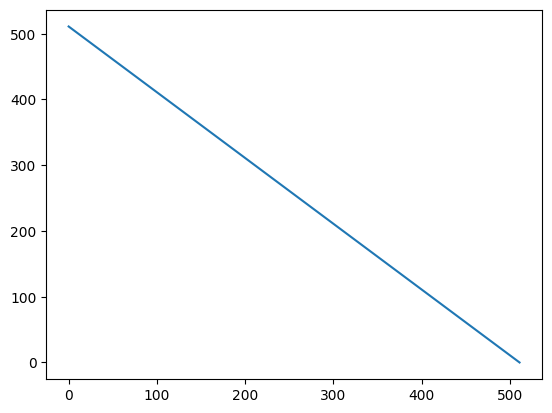

In [12]:
import matplotlib.pyplot as plt
plt.plot((value_list))

In [14]:
import tensorflow as tf
import sonnet as snt
from compgraph.useful import copy_to_non_trainable, compare_sonnet_modules  # Importing custom functions and model class
from compgraph.gnn_src_code import GNN_double_output_advanced

# Initialize two instances of the same GNN architecture
model_a = GNN_double_output_advanced(128,16,1)
model_b = GNN_double_output_advanced(128,16,1)

# Assuming both models are connected to the computational graph and variables are initialized
tf.random.set_seed(42)  # For reproducibility

# Connect models to the computational graph to ensure variables are created
outa= model_a(graph_tuples[0])[0]
outb = model_b(graph_tuples[0])[0]

# Compare the two models to verify that the weights are identical
are_identical = compare_sonnet_modules(model_a, model_b)
print("The models are identical before copying:", are_identical)
copy_to_non_trainable(model_a, model_b)
are_identical2 = compare_sonnet_modules(model_a, model_b)

print("The models are identical after copying:", are_identical2)



The two modules have the same number of layers parameters
The models are identical before copying: True
The two modules have the same number of layers parameters
The models are identical after copying: True


In [18]:
import time
import numpy as np
import tensorflow as tf
import quimb as qu
from compgraph.sparse_ham import compute_wave_function_csr,  innerprod_sparse
from compgraph.tensor_wave_functions import convert_csr_to_sparse_tensor, variational_wave_function_on_batch, time_evoluted_wave_function_on_batch
from compgraph.tensor_wave_functions import montecarlo_logloss_overlap_time_evoluted, sparse_tensor_exp_energy, calculate_sparse_overlap, quimb_vec_to_sparse
from compgraph.gnn_src_code import GNN_double_output_advanced, GNN_double_output
import sonnet as snt
from compgraph.useful import copy_to_non_trainable
initial_learning_rate = 7e-5
model_w=GNN_double_output(128,64)
model_fix=GNN_double_output(128,64)
#THE inner training step should work for one configuration at a time if logic has any ground on reality
# H_no_traversalfield=construct_sparse_hamiltonian(G, 0)


np.set_printoptions(precision=2, suppress=True)
optimizer_snt = snt.optimizers.Adam(initial_learning_rate)
beta=0.05

def inner_training(model_var, model_fix_for_te, graph_batch_var,graph_batch_te, optimizer, beta,sublattice):

    with tf.GradientTape() as tape:
        output = variational_wave_function_on_batch(model_var, graph_batch_var)
        te_wave_on_te= time_evoluted_wave_function_on_batch(model_fix_for_te,beta,graph_batch_te,G)
        tape.watch(model_var.trainable_variables)
        #print("output: \n", output)
            
        loss = montecarlo_logloss_overlap_time_evoluted(te_wave_on_te, graph_batch_te, model_var, model_fix_for_te, graph_batch_var, beta, G)
        
    #print("Is it lossing: \n", loss, type(loss))
    gradients = tape.gradient(loss, model_var.trainable_variables)
    #print("are model variables and gradients two lists?", type(model.trainable_variables), type(gradients))

    #for var, grad in zip(model.trainable_variables, gradients):
    #    print(f"{var.name}: Gradient {'is None' if grad is None else 'exists'}")
    optimizer.apply(gradients, model_var.trainable_variables)
    
    return output, loss


start=0

Hamiltonian_quimb= qu.ham_heis_2D(3, 3, j=1.0, bz=0, cyclic=True, parallel=False, ownership=None)
lowest_eigenstate = qu.groundstate(Hamiltonian_quimb)
lowest_eigenstate_as_sparse = quimb_vec_to_sparse(lowest_eigenstate, full_basis_configs,len(G.nodes))

energies=[]
loss_vectors=[]
overlap_in_time=[]

for step in range(80):  # IT-SWO steps
    # Compute phi once at the beginning of each outer step, this is the ITO of psi

    graph_tuples_batch=full_graph_tuples
    graph_tuples_batch_indices= full_configurations

    model_w(graph_tuples_batch[0])
    model_fix(graph_tuples_batch[0])
    copy_to_non_trainable(model_w, model_fix)

    for innerstep in range(8):  # Inner loop iterations: here we let psi approximate its ITO phi
        
        outputs, loss = inner_training(model_w, model_fix, graph_tuples_batch, graph_tuples_batch, optimizer_snt,beta, sublattice_encoding)
       
        if step % 1 == 0:
            print(f"Step {step}, Loss: {loss.numpy()}")
         # Compute and store energy after updating weights
        psi_sparse= variational_wave_function_on_batch(model_w,graph_tuples_batch)
        normaliz_gnn= 1/tf.norm(psi_sparse.values)
        norm_low_state_gnn= tf.sparse.map_values(tf.multiply, psi_sparse, normaliz_gnn)
        current_energy = sparse_tensor_exp_energy(psi_sparse, G,0)
        overlap_temp= tf.norm(calculate_sparse_overlap(lowest_eigenstate_as_sparse,norm_low_state_gnn))
        overlap_in_time.append(overlap_temp)
        print("Overlap", overlap_temp)
        energies.append(current_energy)
        loss_vectors.append(loss.numpy())
        


Step 0, Loss: (0.006648621965893313-0j)
Overlap tf.Tensor((0.041837266560370553+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.07277880321353589-0j)
Overlap tf.Tensor((0.05715287276998811+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.03175215528729957-0j)
Overlap tf.Tensor((0.05025139726254499+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.02324520030406909-0j)
Overlap tf.Tensor((0.04385398066172146+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.03180236459834229-0j)
Overlap tf.Tensor((0.04540812579185958+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.022197878152666384-0j)
Overlap tf.Tensor((0.049922799265045545+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.015154516200961548-0j)
Overlap tf.Tensor((0.05186225515974238+0j), shape=(), dtype=complex128)
Step 0, Loss: (0.011115916005445202-0j)
Overlap tf.Tensor((0.04891707866578926+0j), shape=(), dtype=complex128)
Step 1, Loss: (0.006484506539276127-0j)
Overlap tf.Tensor((0.04626799655469801+0j), shape=(), dtype=comple

: 

/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


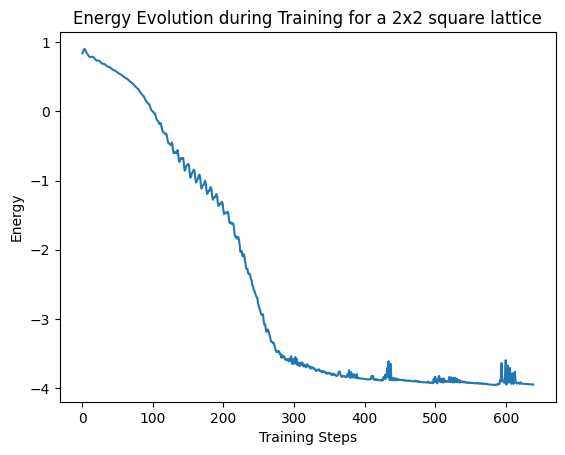

Lowest Energy calculated with quimb: -3.999999999999999
tf.Tensor(
[ 0.01+0.02j  0.02+0.03j  0.  -0.03j  0.16-0.28j  0.02+0.03j  0.13-0.22j
 -0.27+0.49j  0.02+0.j    0.  -0.03j -0.27+0.49j  0.16-0.28j  0.02-0.j
  0.16-0.28j  0.02+0.j    0.02-0.j    0.01+0.02j], shape=(16,), dtype=complex128)
[[ 0.      ]
 [ 0.      ]
 [ 0.      ]
 [-0.288675]
 [ 0.      ]
 [-0.288675]
 [ 0.57735 ]
 [ 0.      ]
 [ 0.      ]
 [ 0.57735 ]
 [-0.288675]
 [ 0.      ]
 [-0.288675]
 [ 0.      ]
 [-0.      ]
 [ 0.      ]]
-3.999999999999999 tf.Tensor((-3.9505677875104612+2.303929616531698e-19j), shape=(), dtype=complex128)


In [15]:
# Plotting the energy
import matplotlib.pyplot as plt
plt.plot(energies[:])
plt.xlabel('Training Steps')
plt.ylabel('Energy')
plt.title('Energy Evolution during Training for a 2x2 square lattice')
plt.show()
n, m= (2,2)
lowest_energy= qu.groundenergy(Hamiltonian_quimb)
print("Lowest Energy calculated with quimb:", lowest_energy)
low_state_gnn= variational_wave_function_on_batch(model_w, graph_tuples_batch)
normaliz_gnn= 1/tf.norm(low_state_gnn.values)
norm_low_state_gnn= tf.sparse.map_values(tf.multiply, low_state_gnn, normaliz_gnn)
print(norm_low_state_gnn.values)
print(lowest_eigenstate)

energy_normalized= sparse_tensor_exp_energy(norm_low_state_gnn, G,0)
print(lowest_energy, energy_normalized)

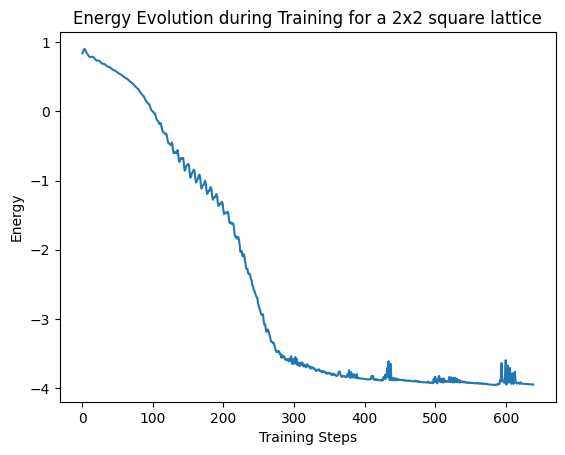

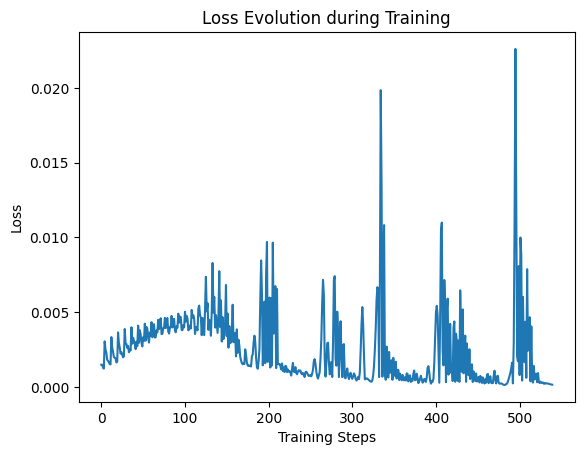

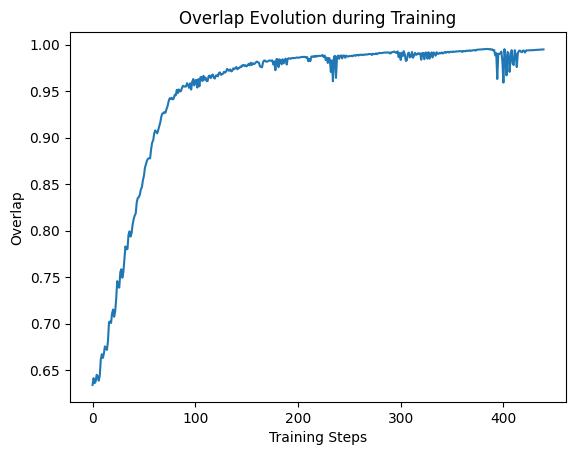

In [16]:
# Plotting the energy
plt.plot(energies[:])
plt.xlabel('Training Steps')
plt.ylabel('Energy')
plt.title('Energy Evolution during Training for a 2x2 square lattice')
plt.show()# Plotting the loss
plt.plot(loss_vectors[100:])
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Loss Evolution during Training')
plt.show()
# Plotting the overlap
plt.plot(overlap_in_time[200:])
plt.xlabel('Training Steps')
plt.ylabel('Overlap')
plt.title('Overlap Evolution during Training')
plt.show()

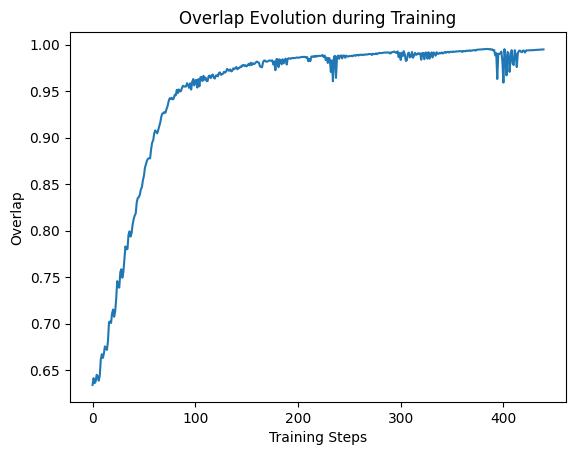

In [17]:
# Plotting the overlap
plt.plot(overlap_in_time[200:])
plt.xlabel('Training Steps')
plt.ylabel('Overlap')
plt.title('Overlap Evolution during Training')
plt.show()

In [18]:
print(tf.norm(low_state_gnn.values))
norm=1/tf.norm(low_state_gnn.values)
normalized_low_state_gnn=tf.sparse.map_values(tf.multiply, low_state_gnn,norm )
print(tf.norm(normalized_low_state_gnn.values))
print(normalized_low_state_gnn.values)
print(np.array(lowest_eigenstate))


tf.Tensor((0.6739542553806863+0j), shape=(), dtype=complex128)
tf.Tensor((0.9999999999999999+0j), shape=(), dtype=complex128)
tf.Tensor(
[ 0.01+0.02j  0.02+0.03j  0.  -0.03j  0.16-0.28j  0.02+0.03j  0.13-0.22j
 -0.27+0.49j  0.02+0.j    0.  -0.03j -0.27+0.49j  0.16-0.28j  0.02-0.j
  0.16-0.28j  0.02+0.j    0.02-0.j    0.01+0.02j], shape=(16,), dtype=complex128)
[[ 0.  ]
 [ 0.  ]
 [ 0.  ]
 [-0.29]
 [ 0.  ]
 [-0.29]
 [ 0.58]
 [ 0.  ]
 [ 0.  ]
 [ 0.58]
 [-0.29]
 [ 0.  ]
 [-0.29]
 [ 0.  ]
 [-0.  ]
 [ 0.  ]]


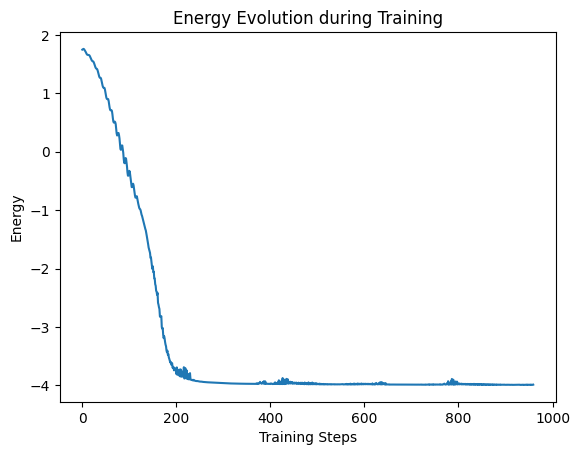

Lowest Energy calculated with quimb: -3.999999999999999
tf.Tensor(
[-0.02+0.01j  0.01+0.j    0.01+0.j   -0.3 +0.j    0.01+0.j   -0.3 +0.j
  0.57+0.02j  0.  +0.01j  0.01+0.j    0.57+0.02j -0.3 +0.j    0.01+0.j
 -0.3 +0.j    0.  +0.01j  0.01+0.j   -0.01+0.01j], shape=(16,), dtype=complex128)
[[ 0.      ]
 [ 0.      ]
 [ 0.      ]
 [-0.288675]
 [ 0.      ]
 [-0.288675]
 [ 0.57735 ]
 [ 0.      ]
 [ 0.      ]
 [ 0.57735 ]
 [-0.288675]
 [ 0.      ]
 [-0.288675]
 [ 0.      ]
 [-0.      ]
 [ 0.      ]]
-3.999999999999999 tf.Tensor((-3.98608727008008-1.782157321023048e-18j), shape=(), dtype=complex128)


In [ ]:
# Plotting the energy
plt.plot(energies[:])
plt.xlabel('Training Steps')
plt.ylabel('Energy')
plt.title('Energy Evolution during Training')
plt.show()
n, m= (2,2)

print("Lowest Energy calculated with quimb:", lowest_energy)
low_state_gnn= variational_wave_function_on_batch(model_w, graph_tuples_batch)
normaliz_gnn= 1/tf.norm(low_state_gnn.values)
norm_low_state_gnn= tf.sparse.map_values(tf.multiply, low_state_gnn, normaliz_gnn)
print(norm_low_state_gnn.values)
print(lowest_eigenstate)

energy_normalized= sparse_tensor_exp_energy(norm_low_state_gnn, G,0)
print(lowest_energy, energy_normalized)

### MonteCarlo update


### 5.1.c
We are now simulating using the functions and importing from an external library.

In [2]:
from compgraph.useful import graph_tuple_list_to_configs_list, sites_to_sparse_updated, sparse_list_to_configs
from compgraph.tensor_wave_functions import variational_wave_function_on_batch, create_sparsetensor_from_configs_amplitudes
import tensorflow as tf
from tensorflow.python.ops.linalg.sparse import sparse_csr_matrix_ops
from scipy.sparse import coo_matrix
import numpy as np
from compgraph.cg_repr import graph_tuple_to_config_hamiltonian_product_update, square_2dham_exp, config_hamiltonian_product 
from compgraph.useful import generate_graph_tuples_configs, sparse_list_to_configs, graph_tuple_list_to_configs_list, sites_to_sparse_updated
import tensorflow as tf
import unittest
import numpy as np
import quimb as qu
import networkx as nx
import tensorflow as tf
from compgraph.cg_repr import *
from compgraph.useful import create_graph_tuples, node_to_index, neel_state, state_from_config_amplitudes, config_to_state
from compgraph.tensor_wave_functions import evaluate_model, variational_wave_function_on_batch, sparse_tensor_exp_energy, create_sparsetensor_from_configs_amplitudes, time_evoluted_wave_function_on_batch, montecarlo_logloss_overlap_time_evoluted, calculate_sparse_overlap, quimb_vec_to_sparse
from simulation.initializer import create_graph_from_ham
import itertools
from compgraph.monte_carlo import MCMCSampler
import importlib
import compgraph.gnn_src_code
# importlib.reload(compgraph.gnn_src_code)
from compgraph.gnn_src_code import GNN_double_output, PoolingLayer_double
def compute_freq_and_amplitudes_from_configurations(configurations, amplitudes):
    """
    configurations is supposed to be a nd.array where the first axis iterates through different configurations
    amplitudes is as well an nd.array with complex entries where
    configurations[0] corresponds to amplitudes[0]
    """
    unique_data = {}  
    unique_data_frequencies={}
    N_samples=len(configurations)
    num_sites=configurations[0].shape[0]
    # Create sparse vector using TensorFlow
    sparse_indices = sites_to_sparse_updated(configurations)
    for idx, sparse_idx in enumerate(sparse_indices):
        if sparse_idx in unique_data:
            unique_data_frequencies[sparse_idx]+=1
            pass
        else:
            unique_data_frequencies[sparse_idx]=1
            unique_data[sparse_idx]=amplitudes[idx]
    values = list(unique_data.values())

    indices = [[key,0] for key in unique_data.keys()]  # Format indices for tf.sparseTensor
    indices_tensor = tf.constant(indices, dtype=tf.int64)
    
    values_tensor = tf.stack(values, axis=0)
    value_frequencies=tf.stack(list(unique_data_frequencies.values()), axis=0)
    sparse_tensor = tf.sparse.SparseTensor(indices=indices_tensor, values=values_tensor, dense_shape=[2**num_sites, 1])
    sparse_tensor_frequency=tf.sparse.SparseTensor(indices=indices_tensor, values=value_frequencies, dense_shape=[2**num_sites, 1])
    return tf.sparse.reorder(sparse_tensor), tf.sparse.reorder(sparse_tensor_frequency)
def create_amplitude_frequencies_from_graph_tuples(graph_tuples, amplitudes):
        
    configurations= graph_tuple_list_to_configs_list(graph_tuples)
    sparse_tensor, freq_amplitudes=compute_freq_and_amplitudes_from_configurations(configurations, amplitudes)
    return tf.sparse.reorder(sparse_tensor), tf.sparse.reorder(freq_amplitudes)

def compute_loss_stochastic(sampler_var, sampler_te, graph_batch_var,graph_batch_te, coeff_te_on_te):
        coeff_var_on_var=[sampler_var.evaluate_model(graph_tuple) for graph_tuple in graph_batch_var]    
        #print("output: \n", output)
        n_sites=len(graph_batch_var[0].nodes[:,0])
        wave_function_var_on_var, freq_var =create_amplitude_frequencies_from_graph_tuples(graph_batch_var, coeff_var_on_var)
        unique_tuples_var=generate_graph_tuples_configs(graph_batch_var[0],sparse_list_to_configs(freq_var.indices[:, 0],n_sites),subl)
        wave_function_te_on_te, freq_te= create_amplitude_frequencies_from_graph_tuples(graph_batch_te, coeff_te_on_te)
        unique_tuples_te=generate_graph_tuples_configs(graph_batch_var[0],sparse_list_to_configs(freq_te.indices[:, 0],n_sites),subl)
        
        coeff_te_on_var=[sampler_te.time_evoluted_config_amplitude(graph_tuple) for graph_tuple in unique_tuples_var]        

        coeff_var_on_te=[sampler_var.evaluate_model(graph_tuple) for graph_tuple in unique_tuples_te]
        
        wave_function_var_on_te, _=create_amplitude_frequencies_from_graph_tuples(unique_tuples_te, coeff_var_on_te)
        wave_function_te_on_var, _= create_amplitude_frequencies_from_graph_tuples(unique_tuples_var, coeff_te_on_var)
        # Convert freq_var to complex if it's not already complex
        freq_var = tf.cast(freq_var.values, dtype=tf.complex128)
        freq_te = tf.cast(freq_te.values, dtype=tf.complex128)
        # ratios_var=freq_var*(wave_function_te_on_var.values)/(wave_function_var_on_var.values)

        # ratios_te = freq_te * tf.math.conj(wave_function_var_on_te.values) / tf.math.conj(wave_function_te_on_te.values)
        # Updated ratio calculations:
        ratios_var = freq_var * tf.math.conj(wave_function_var_on_var.values) * wave_function_te_on_var.values
        ratios_te = freq_te * tf.math.conj(wave_function_te_on_te.values) * wave_function_var_on_te.values
        # print(freq_var, ratios_var)   
        # Compute the overlap
        # overlap = tf.reduce_sum(tf.abs(ratios_var))* tf.reduce_sum(tf.abs(ratios_te))
        overlap = tf.reduce_sum((ratios_var))* tf.reduce_sum((ratios_te))
        normalization_var= tf.reduce_sum(freq_var * tf.math.conj(wave_function_var_on_var.values) * wave_function_var_on_var.values)
        normalization_te=tf.reduce_sum(freq_te * tf.math.conj(wave_function_te_on_te.values) * wave_function_te_on_te.values)
        normalization=1/(normalization_var*normalization_te)
        overlap=tf.math.sqrt(overlap*normalization)
        print(overlap)

        # Calculate the negative log of the overlap
        log_overlap = tf.math.log((overlap)) 
        return -log_overlap   

def inner_training_updated(sampler_var, sampler_te, graph_batch_var,graph_batch_te, coeff_te_on_te, optimizer):
    
    """
    
    Expectation value over the time-evolved distribution:
    E[TE] = sum(|ψ_TE(β)|^2 * (ψ_var_on_TE / ψ_TE_on_TE))= sum((ψ_TE(β)*) o ψ_var_on_TE)
    where |ψ_TE(β)| approx freq(s)/N_samples
    # Where |ψ_TE(β)|^2 represents the norm squared of the time-evolved state coefficients,
    and ψ_var_on_TE / ψ_TE_on_TE is the ratio of variational coefficients to time-evolved coefficients on the TE distribution.
    Returns: -tf.math.log(<overlap>)
    """

    with tf.GradientTape() as tape:
        
        # model_var=sampler_var.model
        tape.watch(sampler_var.model.trainable_variables)
        loss=compute_loss_stochastic(sampler_var, sampler_te, graph_batch_var,graph_batch_te, coeff_te_on_te)
        
    #print("Is it lossing: \n", loss, type(loss))
    gradients = tape.gradient(loss, sampler_var.model.trainable_variables)
    #print("are model variables and gradients two lists?", type(model.trainable_variables), type(gradients))

    #for var, grad in zip(model.trainable_variables, gradients):
    #    print(f"{var.name}: Gradient {'is None' if grad is None else 'exists'}")
    optimizer.apply(gradients, sampler_var.model.trainable_variables)
    # sampler_var.update_model(model_var)
    return  loss

In [8]:
from compgraph.training import outer_training, outer_training_mc
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams, initialize_hamiltonian_and_groundstate, initialize_graph_tuples
import numpy as np
from compgraph.monte_carlo import MCMCSampler
from compgraph.useful import create_graph_tuples
hyperparams = {
    'graph_params':{
    'graphType': '2dsquare',
    'n': 2,
    'm': 2,
    'sublattice':'Neel'
    },
    'sim_params':{
    'beta': 0.05,
    'full_size_hilbert': 'no',
    'batch_size': 32,
    'learning_rate': 7e-5,
    'outer_loop':60,
    'inner_loop': 5,
    'n_batch': 1,
    }
    ,
    'ansatz': 'GNN2adv',
    'ansatz_params': {
        'K_layer':2,
        'hidden_size': 128,
        'output_emb_size': 32
    }
}
graph, subl=create_graph_from_ham(hyperparams['graph_params']['graphType'], (hyperparams['graph_params']['n'],hyperparams['graph_params']['m']), hyperparams['graph_params']['sublattice'] )
print(graph.nodes, graph.edges[(1,0)]['features'], graph.nodes[3])
full_basis_configs = np.array([[int(x) for x in format(i, f'0{len(graph.nodes)}b')] for i in range(2**(len(graph.nodes)))]) * 2 - 1
full_basis_gt=create_graph_tuples(full_basis_configs, graph,subl)

low_eg_asp=initialize_hamiltonian_and_groundstate(hyperparams['graph_params'], full_basis_configs)
model_w=initialize_NQS_model_fromhyperparams(hyperparams['ansatz'], hyperparams['ansatz_params'])
model_fix=initialize_NQS_model_fromhyperparams(hyperparams['ansatz'], hyperparams['ansatz_params'])
graph_tuples_v=initialize_graph_tuples(hyperparams['sim_params']['n_batch']*hyperparams['sim_params']['batch_size'], graph, subl, hyperparams['sim_params']['full_size_hilbert'])
graph_tuples_fix=initialize_graph_tuples(hyperparams['sim_params']['n_batch']*hyperparams['sim_params']['batch_size'], graph, subl, hyperparams['sim_params']['full_size_hilbert'])
len(graph_tuples_v)
sampler_te = MCMCSampler(model_fix, graph_tuples_fix[0], hyperparams['sim_params']['beta'], graph)

# graph_tuples_te, coeff_te_on_te  = zip(*[sampler_te.monte_carlo_update(2, graph_tuple, 'te') for graph_tuple in full_basis_gt])
# coeff_te_on_te

[0, 1, 2, 3] [1.0] {'features': array([0., 1.])}


In [9]:
sampler_var = MCMCSampler(model_w, graph_tuples_fix[0])

graph_tuples_var, coeff_var_on_var = zip(*[sampler_var.monte_carlo_update(2, graph_tuple,'var') for graph_tuple in graph_tuples_v])
coeff_var_on_var

(<tf.Tensor: shape=(), dtype=complex128, numpy=(6.736983302965295-10.491957136537863j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(10.793565415760884-16.809982065914824j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(8.051024593374374-12.538345099883298j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(10.793565415760884-16.809982065914824j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(6.736983302965295-10.491957136537863j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(9.591602928881265-14.938036339923146j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(8.051024593374368-12.53834509988329j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(4.913557139477336-7.418735906591853j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(8.051024593374368-12.53834509988329j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(8.051024593374368-12.53834509988329j)>,
 <tf.Tensor: shape=(), dtype=complex128, numpy=(4.913557139477335-7.418735906591851j)>,
 <tf.Tensor: shape=(), d

In [ ]:
from compgraph.tensor_wave_functions import variational_wave_function_on_batch, time_evoluted_wave_function_on_batch
from compgraph.tensor_wave_functions import sparse_tensor_exp_energy, calculate_sparse_overlap, quimb_vec_to_sparse
import sonnet as snt
from compgraph.useful import copy_to_non_trainable,generate_graph_tuples_configs_new  # Importing custom functions and model class
# from compgraph.monte_carlo import MCMCSampler
from compgraph.training import inner_training
import time
import tensorflow as tf 
from compgraph.useful import graph_tuple_list_to_configs_list, copy_to_non_trainable, compare_sonnet_modules, sites_to_sparse_updated, create_amplitude_frequencies_from_graph_tuples,sparse_list_to_configs
import line_profiler
from compgraph.monte_carlo import stochastic_gradients, stochastic_energy
import atexit
profileliv0 = line_profiler.LineProfiler()
atexit.register(profileliv0.print_stats)

@profileliv0
# model_w=simple_gnn()
# model_fix=simple_gnn()
def outer_training_mc(outer_steps, inner_steps, graph,
                     beta, initial_learning_rate, model_w, model_fix, graph_tuples_var, graph_tuples_te,lowest_eigenstate_as_sparse=None):
    N_sweeps=len(graph_tuples_var[0].nodes)//2
    # N_sweeps=5
    start_time = time.time()
    optimizer_snt = snt.optimizers.Adam(initial_learning_rate)
    energies = []
    loss_vectors = []
    overlap_in_time = []
    # SEED = 42
    # np.random.seed(SEED)
    # tf.random.set_seed(SEED)    
    #TODO Sonnet wants the model to be initialized..., tbh this can be moved to MCMC sampler 
    initialize_model_w = model_w(graph_tuples_var[0])
    initialize_model_fix = model_fix(graph_tuples_te[0])
    # Initialize samplers
    sampler_var = MCMCSampler(model_w, graph_tuples_var[0])
    sampler_te = MCMCSampler(model_fix, graph_tuples_te[0], beta, graph)
    n_sites=len(graph_tuples_v[0].nodes[:,0])
    optimizer = snt.optimizers.Adam(initial_learning_rate,0.95)

    for step in range(outer_steps):
        are_identical = compare_sonnet_modules(sampler_var.model, sampler_te.model)
        print("The models are identical before copying:", are_identical)
        copy_to_non_trainable(sampler_var.model, sampler_te.model)
        are_identical2 = compare_sonnet_modules(sampler_var.model, sampler_te.model)   
        print("The models are identical after copying:", are_identical2)
        # copy_to_non_trainable(model_w, model_fix)

        for innerstep in range(inner_steps):
            # outputs, loss = inner_training(model_w, model_fix, graph_tuples_var, graph_tuples_te, optimizer_snt, beta, sublattice_encoding, graph)
            graph_tuples_var, coeff_var_on_var = zip(*[sampler_var.monte_carlo_update(N_sweeps, graph_tuple,'var') for graph_tuple in graph_tuples_var])
            # sampler_var.update_model(model_w)
            configs_var=sites_to_sparse_updated(graph_tuple_list_to_configs_list(graph_tuples_var))

            print(f'configs var: {configs_var}')
            # Temporarily modified in asking two times the graph_tuples var
            wave_function_var_on_var, freq_var = create_amplitude_frequencies_from_graph_tuples(graph_tuples_var, coeff_var_on_var)
            freq_ampl_var = np.array(freq_var.values) / len(graph_tuples_var)
            unique_tuples_var = generate_graph_tuples_configs_new(graph_tuples_var[0], sparse_list_to_configs(freq_var.indices[:, 0], n_sites))

            stoch_gradients=stochastic_gradients(sampler_var,sampler_te,unique_tuples_var,freq_ampl_var)
            #print("check of new inner functions", outputs==outputs2, loss==loss2)
            optimizer.apply(stoch_gradients, sampler_var.model.trainable_variables)            
            stoch_energy=stochastic_energy(sampler_var,graph,unique_tuples_var,freq_ampl_var)

            energies.append(stoch_energy[0].numpy())
            print('stoch energy',stoch_energy[0].numpy(), 'freq', freq_ampl_var)

            # print(wave_function_var_on_var)

        # if lowest_eigenstate_as_sparse is not None:
                
        #     overlap_temp = tf.norm(calculate_sparse_overlap(lowest_eigenstate_as_sparse, norm_low_state_gnn))

        #     overlap_in_time.append(overlap_temp.numpy())
        # else:
        #     overlap_in_time.append('NA')    
        # print(f'at step{step}:{innerstep} energy is {current_energy.numpy()}, loss is {loss.numpy()}, overlap is {overlap_temp.numpy()}')

    endtime = time.time() - start_time
    return endtime, energies, loss_vectors, overlap_in_time, model_w, graph_tuples_var, graph_tuples_te

lista=outer_training_mc(80,5,
                     graph, 0.06, 7e-4,model_w,model_fix,graph_tuples_v,graph_tuples_fix,low_eg_asp)

The two modules have the same number of layers parameters
The models are identical before copying: True
The two modules have the same number of layers parameters
The models are identical after copying: True
configs var: [0, 10, 11, 10, 15, 5, 5, 15, 2, 6, 6, 4, 15, 3, 5, 12, 12, 3, 12, 12, 3, 10, 8, 12, 2, 3, 12, 12, 3, 4, 12, 0]
stoch energy (4.453156919405142-1.5447028649544088e-06j) freq [0.0625  0.0625  0.15625 0.0625  0.09375 0.0625  0.03125 0.09375 0.03125
 0.25    0.09375]
configs var: [4, 11, 9, 9, 15, 0, 13, 11, 4, 6, 6, 0, 15, 0, 6, 12, 15, 2, 14, 15, 9, 9, 14, 15, 6, 15, 4, 9, 3, 6, 15, 0]
stoch energy (1.4273276196834481+6.390953967366257e-09j) freq [0.125   0.03125 0.03125 0.09375 0.15625 0.15625 0.0625  0.03125 0.03125
 0.0625  0.21875]
configs var: [13, 11, 5, 15, 7, 0, 9, 13, 4, 4, 14, 9, 15, 0, 7, 13, 15, 8, 6, 14, 9, 9, 13, 15, 6, 11, 4, 12, 1, 6, 15, 10]
stoch energy (1.7667008993675382+3.2620081266337186e-10j) freq [0.0625  0.03125 0.09375 0.03125 0.09375 0.0625  0.

In [ ]:
profileliv0.print_stats()

In [1]:
import quimb as qu 
n,m =(3,3)
Hamiltonian=qu.ham_heis_2D(n, m, j=1.0, bz=0, cyclic=True, parallel=False, ownership=None)
from compgraph.useful import state_from_config_amplitudes
from compgraph.tensor_wave_functions import create_sparsetensor_from_configs_amplitudes
sampler_var=MCMCSampler(lista[4], full_basis_gt[0])
wf_var_on_full=[sampler_var.evaluate_model(gt) for gt in full_basis_gt]
amplitudes_var =np.array(wf_var_on_full)
psi_full=state_from_config_amplitudes(full_basis_configs,amplitudes_var)
full_basis_configs = np.array([[int(x) for x in format(i, f'0{len(graph.nodes)}b')] for i in range(2**(len(graph.nodes)))]) * 2 - 1
wf_var_on_full
full_basis_gt=create_graph_tuples(full_basis_configs, graph,subl)
var_model_full=create_sparsetensor_from_configs_amplitudes(full_basis_configs,wf_var_on_full/(tf.norm(wf_var_on_full)),4)

/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
2024-10-06 21:51:18.896553: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-06 21:51:22.644881: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


NameError: name 'MCMCSampler' is not defined

In [18]:
psi_full.H@Hamiltonian@psi_full/(psi_full.H@psi_full)

[[-2.497192+2.346736e-17j]]

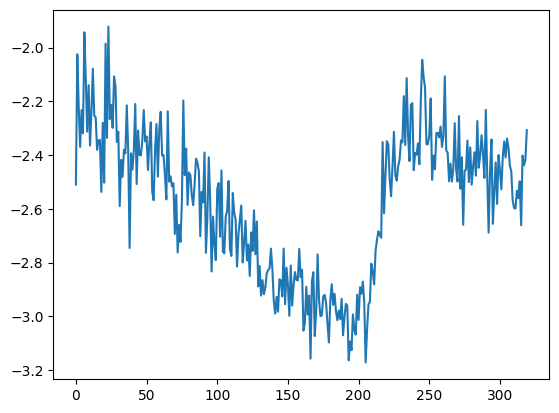

In [20]:
import matplotlib.pyplot as plt
plt.plot(lista[1][160:])

In [ ]:
from simulation.data_handling import flatten_dict

# Example usage
hyperparams = {
    'graph_params': {
        'graphType': '2dsquare',
        'n': 2,
        'm': 2,
        'sublattice': 'Neel'
    },
    'sim_params': {
        'beta': 0.07,
        'outer_loop': 90,
        
        'full_size_hilbert': 'yes',
        'batch_size': 8,
        'n_batch': 2,

        'learning_rate': 7e-5,
        'inner_loop': 7,
    },
    'ansatz': 'GNN2simple',
    'ansatz_params': {
        'hidden_size': 64,
        'output_emb_size': 16
    }
}

flat_hyperparams = flatten_dict(hyperparams)
print(flat_hyperparams)


{'graphType': '2dsquare', 'n': 2, 'm': 2, 'sublattice': 'Neel', 'beta': 0.07, 'full_size_hilbert': 'yes', 'batch_size': 8, 'n_batch': 2, 'learning_rate': 7e-05, 'outer_loop': 90, 'inner_loop': 7, 'ansatz': 'GNN2simple', 'hidden_size': 64, 'output_emb_size': 16}


In [ ]:
"""
energies = df['energies'].iloc[0]
loss_vectors = df['loss_vectors'].iloc[0]
overlap_in_time = df['overlap_in_time'].iloc[0]
"""


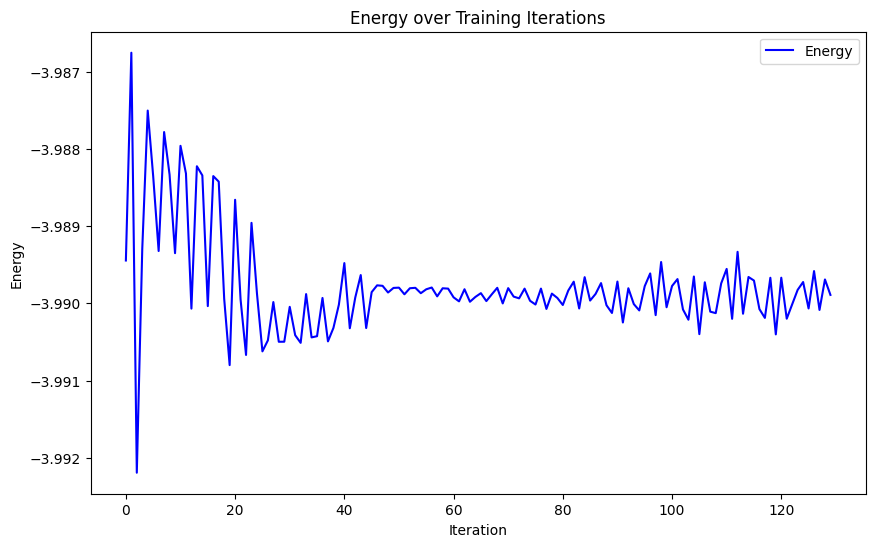

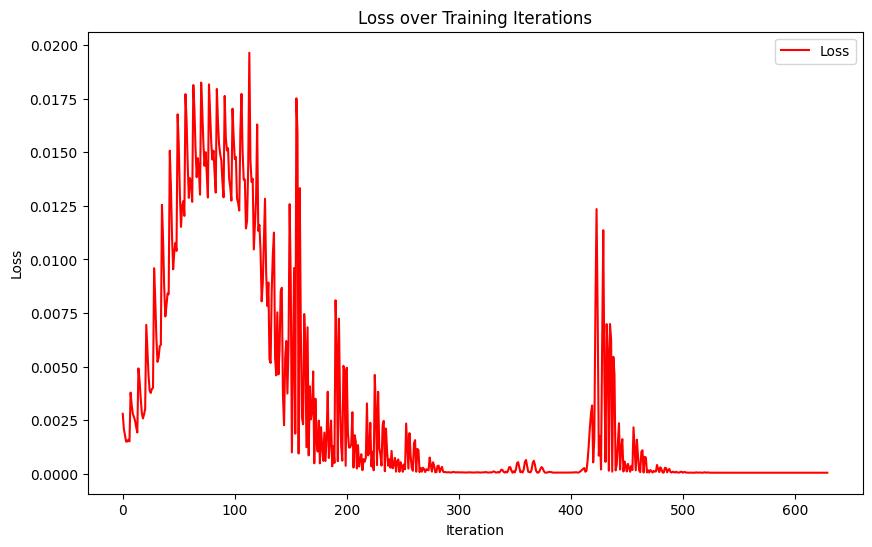

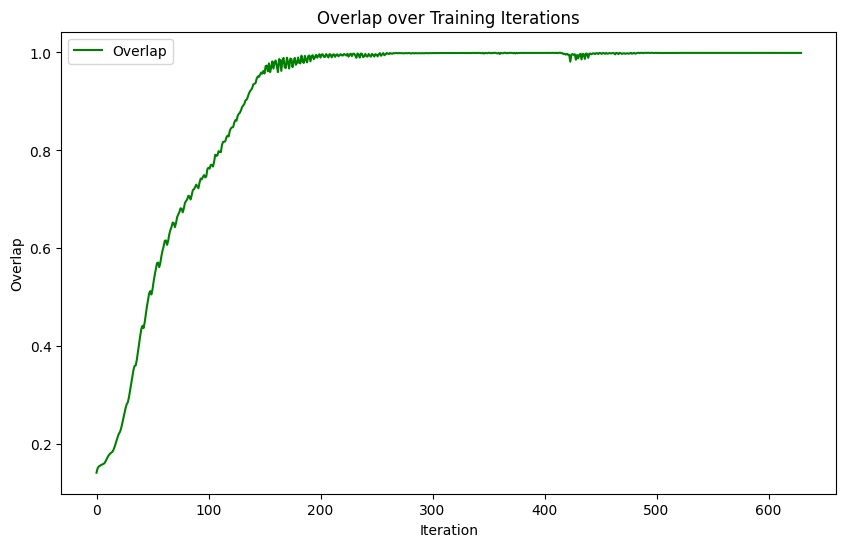

In [ ]:
# Plotting Energies
plt.figure(figsize=(10, 6))
plt.plot(energies[500:], label='Energy', color='blue')
plt.title('Energy over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.legend()
plt.show()

# Plotting Loss Vectors
plt.figure(figsize=(10, 6))
plt.plot(loss_vectors, label='Loss', color='red')
plt.title('Loss over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Overlap in Time
plt.figure(figsize=(10, 6))
plt.plot(overlap_in_time, label='Overlap', color='green')
plt.title('Overlap over Training Iterations')
plt.xlabel('Iteration')
plt.ylabel('Overlap')
plt.legend()
plt.show()


## 6 
#### In the previous section we managed to perform all the operations we wanted to do while preserving the gradient. Hurra! 
In this section we will include the montecarlo update and try to stabilize the parameters

In [1]:

from compgraph.training import outer_training
from simulation.initializer import create_graph_from_ham, initialize_NQS_model_fromhyperparams, initialize_hamiltonian_and_groundstate, initialize_graph_tuples
import numpy as np
hyperparams = {
    'graph_params':{
    'graphType': '2dsquare',
    'n': 2,
    'm': 2,
    'sublattice':'Neel'
    },
    'sim_params':{
    'beta': 0.05,
    'batch_size': 8,
    'learning_rate': 7e-5,
    'n_batch': 1,
    }
    ,
    'ansatz': 'GNN2adv',
    'ansatz_params': {
        'K_layer':1,
        'hidden_size': 128,
        'output_emb_size': 64
    }
}
graph, subl = create_graph_from_ham(
    hyperparams['graph_params']['graphType'],
    (hyperparams['graph_params']['n'], hyperparams['graph_params']['m']),
    hyperparams['graph_params']['sublattice']
)

# Generate the full basis configurations for the system
full_basis_configs = np.array([[int(x) for x in format(i, f'0{len(graph.nodes)}b')] for i in range(2**(len(graph.nodes)))]) * 2 - 1
lowest_eigenstate_as_sparse = initialize_hamiltonian_and_groundstate(hyperparams['graph_params'], full_basis_configs)

# Initialize the variational and fixed models
model_w = initialize_NQS_model_fromhyperparams(hyperparams['ansatz'], hyperparams['ansatz_params'])
model_fix = initialize_NQS_model_fromhyperparams(hyperparams['ansatz'], hyperparams['ansatz_params'])

# Generate tuples of graphs for variational training and fixed comparisons
graph_tuples_var = initialize_graph_tuples(
    hyperparams['sim_params']['n_batch'] * hyperparams['sim_params']['batch_size'],
    graph, subl)
graph_tuples_fix = initialize_graph_tuples(
    hyperparams['sim_params']['n_batch'] * hyperparams['sim_params']['batch_size'],
    graph, subl)


2024-11-22 08:04:39.963868: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 08:04:40.749338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
2024-11-22 08:04:43.653149: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-22 08:04:43.703388: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251]

In [2]:
len(graph_tuples_fix)

8

In [3]:
energies = []
loss_vectors = []
overlap_in_time = []
initialize_model_w = model_w(graph_tuples_var[0])
initialize_model_fix = model_fix(graph_tuples_fix[0])
start = 0

### Block for MC update benchmarking


In [5]:
from compgraph.monte_carlo import parallel_monte_carlo_update, monte_carlo_update, sequential_monte_carlo_update
batch_size = hyperparams['sim_params']['batch_size']
beta=hyperparams['sim_params']['beta']
 
    #graph_tuples_var_batch = rolling_window_batch(graph_tuples_var, start, batch_size)
    #graph_tuples_te_batch = rolling_window_batch(graph_tuples_fix, start, batch_size)
#print(graph_tuples_var_batch[0].nodes)
# Monte Carlo update for the batches using multiprocessing
#graph_tuples_var= parallel_monte_carlo_update(graph_tuples_var, model_w, N_sweeps=1, approach='var')
#print(graph_tuples_var_batch[0].nodes)
#graph_tuples_fix = parallel_monte_carlo_update(graph_tuples_fix, model_fix, N_sweeps=5, approach='te', beta=beta, graph=graph, sublattice_encoding=subl)


In [7]:
import time
start_time = time.time()
graph_tuples_var_batch=sequential_monte_carlo_update(graph_tuples_var, model_w, 4, approach='var', beta=None, graph=None, sublattice_encoding=None)
print(time.time() - start_time)
start_time = time.time()
graph_tuples_fix = sequential_monte_carlo_update(graph_tuples_fix, model_fix, N_sweeps=5, approach='te', beta=beta, graph=graph, sublattice_encoding=subl)
print(time.time() - start_time)

0.3414630889892578


TypeError: time_evoluted_config_amplitude() takes 4 positional arguments but 5 were given

In [6]:
import time 
from compgraph.monte_carlo import parallel_monte_carlo_update, monte_carlo_update, sequential_monte_carlo_update

start_time = time.time()
graph_tuples_var = initialize_graph_tuples(
    1000,
    graph, subl)
print(time.time()-start_time)

9.750802516937256


In [15]:
from compgraph.tensor_wave_functions import variational_wave_function_on_batch
from compgraph.monte_carlo import parallel_monte_carlo_update, monte_carlo_update, sequential_monte_carlo_update
import tensorflow as tf
start_time = time.time()

for gt in graph_tuples_var[:10]:
    model_w(gt)
print("Time for running 100 times the model",time.time()-start_time)
start_time = time.time()
variational_wave_function_on_batch(model_w,graph_tuples_var[:10])

print("Time for running the model function once on 100- configs",time.time()-start_time)
start_time = time.time()
with tf.device("/GPU:0"):
    parallel_monte_carlo_update(graph_tuples_var[:4],model_w,1, 'var')
print("time for doing the same with MC updates, should take twice (times 3) the time as before roughly", time.time()-start_time)
start_time = time.time()
parallel_monte_carlo_update(graph_tuples_fix[:4], model_fix, 1, 'te',
                             beta=hyperparams['sim_params']['beta'], graph=graph, sublattice_encoding=subl)
print("time for doing the same with MC updates on model_fix, should take twice (times nx*ny)/10 the time as before roughly", time.time()-start_time)


Time for running 100 times the model 0.8343842029571533
Time for running the model function once on 100- configs 0.8293986320495605


2024-07-07 17:31:28.321547: F external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:155] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2024-07-07 17:31:28.397282: F external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:155] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2024-07-07 17:31:28.477410: F external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:155] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2024-07-07 17:31:28.559265: F external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:155] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error


KeyboardInterrupt: 

### Simulation block

In [8]:
from compgraph.training import rolling_window_batch, inner_training
from compgraph.monte_carlo import parallel_monte_carlo_update, monte_carlo_update, sequential_monte_carlo_update
from compgraph.useful import copy_to_non_trainable
from compgraph.tensor_wave_functions import calculate_sparse_overlap, sparse_tensor_exp_energy,  variational_wave_function_on_batch 
import time
import tensorflow as tf
import sonnet as snt
%reload_ext autoreload
%autoreload 2
batch_size = hyperparams['sim_params']['batch_size']
beta=hyperparams['sim_params']['beta']
start_time = time.time()
optimizer_snt = snt.optimizers.Adam(hyperparams['sim_params']['learning_rate'])

start = 0
inn_steps=5
for step in range(200):
    print('step number: ', step)
    copy_to_non_trainable(model_w, model_fix)
    #graph_tuples_var_batch = rolling_window_batch(graph_tuples_var, start, batch_size)
    #graph_tuples_te_batch = rolling_window_batch(graph_tuples_fix, start, batch_size)
    #print(graph_tuples_var_batch[0].nodes)
    # Monte Carlo update for the batches using multiprocessing
    #graph_tuples_var[start:end] = parallel_monte_carlo_update(graph_tuples_var[start:end], model_w, N_sweeps=4, approach='var')
    #print(graph_tuples_var_batch[0].nodes)
    graph_tuples_fix = sequential_monte_carlo_update(graph_tuples_fix, model_fix, N_sweeps=5, approach='te', beta=beta, graph=graph, sublattice_encoding=subl)
    graph_tuples_te_batch=graph_tuples_fix
    temp_energy=0.
    temp_overlap=0.
    for innerstep in range(inn_steps):
        graph_tuples_var_batch=graph_tuples_var
        outputs, loss = inner_training(model_w, model_fix, graph_tuples_var_batch, graph_tuples_te_batch, optimizer_snt, beta, subl, graph)

        normaliz_gnn = 1 / tf.norm(outputs.values)
        norm_low_state_gnn = tf.sparse.map_values(tf.multiply, outputs, normaliz_gnn)
        current_energy = sparse_tensor_exp_energy(outputs, graph, 0)
        overlap_temp = tf.norm(calculate_sparse_overlap(lowest_eigenstate_as_sparse, norm_low_state_gnn))
        temp_overlap+=overlap_temp.numpy()/inn_steps
        temp_energy+=current_energy.numpy()/inn_steps
        loss_vectors.append(loss.numpy())
        print('Little step', 'overlap',overlap_temp.numpy(), "energy", current_energy.numpy())

        graph_tuples_var= sequential_monte_carlo_update(graph_tuples_var_batch, model_w, N_sweeps=4, approach='var')
    """
    vec=variational_wave_function_on_batch(model_w, graph_tuples_var)
    normaliz_gnn = 1 / tf.norm(outputs.values)
    norm_low_state_gnn = tf.sparse.map_values(tf.multiply, outputs, normaliz_gnn)
    current_energy = sparse_tensor_exp_energy(outputs, graph, 0)
    overlap_temp = tf.norm(calculate_sparse_overlap(lowest_eigenstate_as_sparse, norm_low_state_gnn))
    """
    energies.append(temp_energy)
    overlap_in_time.append(temp_overlap)

    print(temp_overlap, temp_energy)

endtime = time.time() - start_time


step number:  0
Little step overlap (0.1861331427035196+0j) energy (0.9981829049721697+0j)
Little step overlap (0.09333872164765183+0j) energy (0.846781912321905+0j)
Little step overlap (0.1388823886515575+0j) energy (0.40824579433175984+0j)
Little step overlap (0.17648778646322022+0j) energy (1.0298722575659187+0j)
Little step overlap (0.2758577188847216+0j) energy (0.527917731552212+0j)
(0.17413995167013419+0j) (0.7622001201487931+0j)
step number:  1
Little step overlap (0.004583878575899661+0j) energy (0.8044871542854084+0j)
Little step overlap (0.38303086400578684+0j) energy (-0.5592591478466269+0j)
Little step overlap (0.08485650559243894+0j) energy (1.0221807878473332+0j)
Little step overlap (0.12587235812046785+0j) energy (1.196482017649554+0j)
Little step overlap (0.13852460274607564+0j) energy (0.17442814667487067+0j)
(0.1473736418081338+0j) (0.5276637917221079+0j)
step number:  2
Little step overlap (0.15268693283259338+0j) energy (1.4550559773230374+0j)
Little step overlap (

: 

In [ ]:
start_time = time.time()

for gt in graph_tuples_var_batch:
    monte_carlo_update(gt, model_w, N_sweeps=2, approach='var')
print(time.time() - start_time)

0.22401189804077148


/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


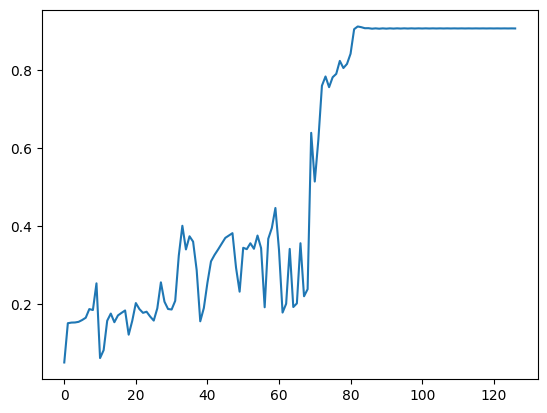

In [10]:
import matplotlib.pyplot as plt

plt.plot(overlap_in_time)

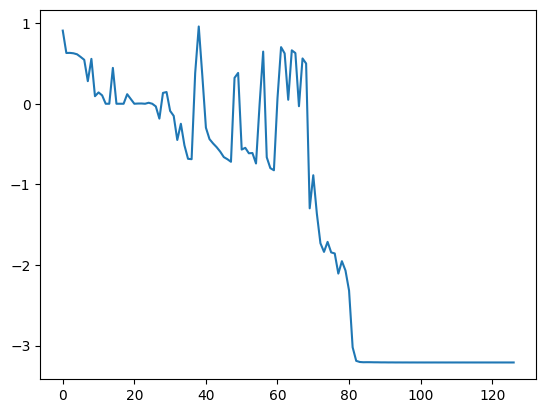

In [11]:
plt.plot(energies)

/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


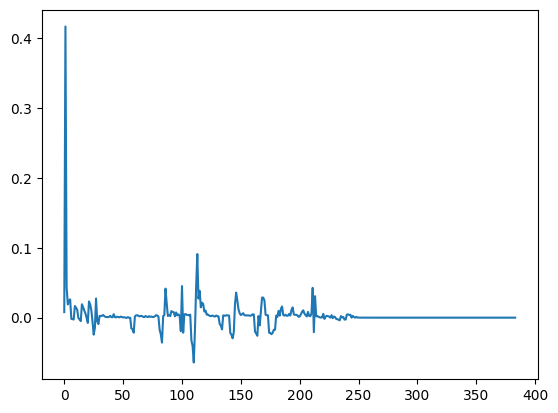

In [12]:
plt.plot(loss_vectors)

In [298]:
gnn_state_of_distribution= variational_wave_function_on_batch(model_w, graph_tuples_var)
normaliz_gnn_factor=1/tf.norm(gnn_state_of_distribution.values)
norm_low_state_gnn_dist = tf.sparse.map_values(tf.multiply, gnn_state_of_distribution, normaliz_gnn_factor)

overlap_temp = tf.norm(calculate_sparse_overlap(lowest_eigenstate_as_sparse, norm_low_state_gnn_dist))
print(overlap_temp)

tf.Tensor((0.22904728447591932+0j), shape=(), dtype=complex128)


In [283]:
graph_tuples_var_batch = rolling_window_batch(graph_tuples_var, 0, 8)
#print(graph_tuples_var_batch[0].nodes)
# Monte Carlo update for the batches using multiprocessing
upd_graph_tuples_var_batch = parallel_monte_carlo_update(graph_tuples_var_batch, model_w, N_sweeps=40, approach='var')
from compgraph.useful import compare_graph_tuples
compare_graph_tuples(upd_graph_tuples_var_batch,rolling_window_batch(graph_tuples_var, 0, 8))


False

In [287]:
type(graph_tuples_var[0])

graph_nets.graphs.GraphsTuple

In [259]:
graph_tuples_var_for_distribution = initialize_graph_tuples(
    200,
    graph, subl)

In [285]:
print(graph_tuples_var_for_distribution[0].nodes[0:,])
upd_tuple=monte_carlo_update(graph_tuples_var_for_distribution[0], model_w, 3, approach='var')
print(upd_tuple.nodes[0:,])
print(graph_tuples_var_for_distribution[0].nodes[0:,])


tf.Tensor(
[[-1.  1.  0.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]
 [-1.  0.  1.]], shape=(4, 3), dtype=float64)
tf.Tensor(
[[-1.  1.  0.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]
 [ 1.  0.  1.]], shape=(4, 3), dtype=float64)
tf.Tensor(
[[-1.  1.  0.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]
 [-1.  0.  1.]], shape=(4, 3), dtype=float64)


In [260]:
from compgraph.monte_carlo import parallel_monte_carlo_update,sequential_monte_carlo_update, monte_carlo_update
vect_before=create_sparsetensor_from_mc_update(graph_tuples_var_for_distribution)
# Generate tuples of graphs for variational training and fixed comparisons

update_graph_tuples_mc=parallel_monte_carlo_update(graph_tuples_var_for_distribution, model_w, N_sweeps=40, approach='var')
vect_later=create_sparsetensor_from_mc_update(graph_tuples_var_for_distribution)
vect_update= create_sparsetensor_from_mc_update(update_graph_tuples_mc)

/home/stefanotroffa/miniconda3/envs/gnets2/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [264]:
print(vect_before.values)
print(vect_later.values)
print(vect_update.values)

tf.Tensor(
[0.25495097 0.24494897 0.2738613  0.24494897 0.2345208  0.18708287
 0.2236068  0.2828427  0.30822068 0.2236068  0.2        0.24494897
 0.26457512 0.2345208  0.2915476  0.25495097], shape=(16,), dtype=float32)
tf.Tensor(
[0.25495097 0.24494897 0.2738613  0.24494897 0.2345208  0.18708287
 0.2236068  0.2828427  0.30822068 0.2236068  0.2        0.24494897
 0.26457512 0.2345208  0.2915476  0.25495097], shape=(16,), dtype=float32)
tf.Tensor(
[0.12247448 0.54313904 0.25495097 0.33166248 0.07071067 0.18708287
 0.33166248 0.21213204 0.12247448 0.38078865 0.2236068  0.17320508
 0.2828427 ], shape=(13,), dtype=float32)


In [262]:
from compgraph.useful import sparse_list_to_configs, graph_tuple_list_to_configs_list
from collections import Counter
from compgraph.useful import sites_to_sparse
from compgraph.tensor_wave_functions import create_sparsetensor_from_configs_amplitudes
def create_sparsetensor_from_mc_update(graph_tuples):
    # Transform graph_tuples_var_for_distribution using sparse_list_to_configs
    distrib_mc_update = graph_tuple_list_to_configs_list(graph_tuples)
    # Count occurrences of each configuration
    mc_update_count = Counter(tuple(config.tolist()) for config in distrib_mc_update)

    # Normalize the counts to create a distribution
    total_counts = sum(mc_update_count.values())
    normalized_mc_dist = {config: count / total_counts for config, count in mc_update_count.items()}

    sites_to_sparse(list(mc_update_count.keys())) 
    sparse_from_counter=create_sparsetensor_from_configs_amplitudes(list(normalized_mc_dist.keys()), list(normalized_mc_dist.values()),4)
    # Sort the dictionary keys
    norm_counter_dist_from_mc = tf.sparse.map_values(tf.math.sqrt, sparse_from_counter)
    return norm_counter_dist_from_mc


In [246]:
# Transform graph_tuples_var_for_distribution using sparse_list_to_configs
distrib_mc_update = graph_tuple_list_to_configs_list(graph_tuples)
# Count occurrences of each configuration
mc_update_count = Counter(tuple(config.tolist()) for config in distrib_mc_update)

# Normalize the counts to create a distribution
total_counts = sum(mc_update_count.values())
normalized_mc_dist = {config: count / total_counts for config, count in mc_update_count.items()}

sites_to_sparse(list(mc_update_count.keys())) 

#print(list(normalized_mc_dist.keys()))
#print(list(normalized_mc_dist.values()), sum(list(normalized_mc_dist.values())))
#print(sites_to_sparse(list(mc_update_count.keys()))[1] )

# Sort the dictionary keys
sorted_keys = sorted(normalized_mc_dist.keys())
sorted_counter_dict = {key: normalized_mc_dist[key] for key in sorted_keys}
print(sorted_keys)
sqrt_values = [value**(2) for value in sorted_counter_dict.values()]

print(list(sorted_counter_dict.values()))
print(sites_to_sparse(list(sorted_keys))[1])

print("Tensor made from the mc distribution occurence",sparse_from_counter.values, list(np.array(sparse_from_counter.indices)))
print(tf.norm(sparse_from_counter.values))
norm_counter_dist_from_mc = tf.sparse.map_values(tf.math.sqrt, sparse_from_counter)
print(norm_counter_dist_from_mc.values)
#print(tf.norm(norm_counter_dist_from_mc.values))


[(-1.0, -1.0, -1.0, -1.0), (-1.0, -1.0, -1.0, 1.0), (-1.0, -1.0, 1.0, -1.0), (-1.0, -1.0, 1.0, 1.0), (-1.0, 1.0, -1.0, -1.0), (1.0, -1.0, -1.0, -1.0), (1.0, -1.0, 1.0, -1.0), (1.0, -1.0, 1.0, 1.0), (1.0, 1.0, -1.0, -1.0), (1.0, 1.0, 1.0, -1.0)]
[0.17, 0.07, 0.07, 0.295, 0.115, 0.005, 0.055, 0.085, 0.01, 0.125]
[15, 14, 13, 12, 11, 7, 5, 4, 3, 1]
Tensor made from the mc distribution occurence tf.Tensor([0.125 0.01  0.085 0.055 0.005 0.115 0.295 0.07  0.07  0.17 ], shape=(10,), dtype=float32) [array([1, 0]), array([3, 0]), array([4, 0]), array([5, 0]), array([7, 0]), array([11,  0]), array([12,  0]), array([13,  0]), array([14,  0]), array([15,  0])]
tf.Tensor(0.40614036, shape=(), dtype=float32)
tf.Tensor(
[0.35355338 0.1        0.2915476  0.2345208  0.07071067 0.3391165
 0.54313904 0.26457512 0.26457512 0.41231057], shape=(10,), dtype=float32)


SparseTensor(indices=tf.Tensor(
[[ 1  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 7  0]
 [11  0]
 [12  0]
 [13  0]
 [14  0]
 [15  0]], shape=(10, 2), dtype=int64), values=tf.Tensor(
[0.35355338 0.1        0.2915476  0.2345208  0.07071067 0.3391165
 0.54313904 0.26457512 0.26457512 0.41231057], shape=(10,), dtype=float32), dense_shape=tf.Tensor([16  1], shape=(2,), dtype=int64))

In [239]:
gnn_state_of_distribution= variational_wave_function_on_batch(model_w, update_graph_tuples_mc)
#gnn_state_of_distribution= variational_wave_function_on_batch(model_w, graph_tuples_var_for_distribution)

#print(norm_low_state_gnn_dist)
#print(tf.norm(norm_low_state_gnn_dist.values))
print(gnn_state_of_distribution.values)
normaliz_gnn_factor=1/tf.norm(gnn_state_of_distribution.values)
norm_low_state_gnn_dist = tf.sparse.map_values(tf.multiply, gnn_state_of_distribution, normaliz_gnn_factor)

amplitude_norm_gnn=tf.sparse.map_values(tf.math.abs, norm_low_state_gnn_dist)
print(tf.norm(gnn_state_of_distribution.values),tf.norm(amplitude_norm_gnn.values))
print(amplitude_norm_gnn.values)
print(tf.norm(amplitude_norm_gnn.values))


tf.Tensor(
[0.19993856-0.09667002j 0.09100995-0.23292403j 0.19993856-0.09667002j
 0.15044962-0.03452722j 0.03431189-0.16953711j 0.06653752-0.13802854j
 0.09100995-0.23292403j 0.03431189-0.16953711j 0.06653752-0.13802854j
 0.0462981 -0.20528071j], shape=(10,), dtype=complex128)
tf.Tensor((0.6313662092640203+0j), shape=(), dtype=complex128) tf.Tensor(0.9999999999999999, shape=(), dtype=float64)
tf.Tensor(
[0.35174869 0.39608205 0.35174869 0.24448675 0.27396839 0.2426943
 0.39608205 0.27396839 0.2426943  0.33330401], shape=(10,), dtype=float64)
tf.Tensor(0.9999999999999999, shape=(), dtype=float64)


In [240]:
 
print(norm_counter_dist_from_mc)
amplitude_norm_gnn

SparseTensor(indices=tf.Tensor(
[[ 1  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 7  0]
 [11  0]
 [12  0]
 [13  0]
 [14  0]
 [15  0]], shape=(10, 2), dtype=int64), values=tf.Tensor(
[0.35355338 0.1        0.2915476  0.2345208  0.07071067 0.3391165
 0.54313904 0.26457512 0.26457512 0.41231057], shape=(10,), dtype=float32), dense_shape=tf.Tensor([16  1], shape=(2,), dtype=int64))


SparseTensor(indices=tf.Tensor(
[[ 1  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 7  0]
 [11  0]
 [12  0]
 [13  0]
 [14  0]
 [15  0]], shape=(10, 2), dtype=int64), values=tf.Tensor(
[0.35174869 0.39608205 0.35174869 0.24448675 0.27396839 0.2426943
 0.39608205 0.27396839 0.2426943  0.33330401], shape=(10,), dtype=float64), dense_shape=tf.Tensor([16  1], shape=(2,), dtype=int64))

In [241]:
from compgraph.tensor_wave_functions import evaluate_model
from compgraph.useful import graph_tuple_toconfig, sites_to_sparse
unique_data = {}  # Dictionary to store unique indices and their corresponding values
size=2**len(graph_tuples_var_for_distribution[0].nodes)
for graph_tuple in graph_tuples_var_for_distribution:
    #print(graph_batch_indices, type(graph_batch_indices))
    # Extract the row index from the configuration
    config=graph_tuple_toconfig(graph_tuple)
    sparse_not= sites_to_sparse([config])[0][0]
    row_index = sparse_not.indices[0]        # Check if the index is already in the dictionary
    if row_index in unique_data:
        pass  # Sum up the values for repeated indices
    else:
        unique_data[row_index] = config
#print(unique_data)
#gnn_state_of_distribution

In [242]:
"""
from compgraph.useful import sparse_list_to_configs
indices_from_mc=np.array(norm_counter_dist_from_mc.indices)[:, 0]
sparse_list_to_configs(indices_from_mc,4)
"""

'\nfrom compgraph.useful import sparse_list_to_configs\nindices_from_mc=np.array(norm_counter_dist_from_mc.indices)[:, 0]\nsparse_list_to_configs(indices_from_mc,4)\n'

In [245]:
print(norm_counter_dist_from_mc)
print(amplitude_norm_gnn.values)

SparseTensor(indices=tf.Tensor(
[[ 1  0]
 [ 3  0]
 [ 4  0]
 [ 5  0]
 [ 7  0]
 [11  0]
 [12  0]
 [13  0]
 [14  0]
 [15  0]], shape=(10, 2), dtype=int64), values=tf.Tensor(
[0.35355338 0.1        0.2915476  0.2345208  0.07071067 0.3391165
 0.54313904 0.26457512 0.26457512 0.41231057], shape=(10,), dtype=float32), dense_shape=tf.Tensor([16  1], shape=(2,), dtype=int64))
tf.Tensor(
[0.35174869 0.39608205 0.35174869 0.24448675 0.27396839 0.2426943
 0.39608205 0.27396839 0.2426943  0.33330401], shape=(10,), dtype=float64)


In [244]:
"""
left_part=amplitude_norm_gnn
right_part=norm_counter_dist_from_mc
conjugated_te = tf.sparse.map_values(tf.math.conj, left_part)
wave_left_with_0=tf.sparse.map_values(tf.multiply,conjugated_te, 0)
wave_right_with_0= tf.sparse.map_values(tf.multiply,right_part, 0.)
print(wave_left_with_0,wave_right_with_0)
wave_0=tf.sparse.add(wave_right_with_0,wave_left_with_0)
conjugated_te=tf.sparse.add(conjugated_te,wave_0)
right_part= tf.sparse.add(right_part,wave_0)
# Element-wise multiplication of sparse tensors
product_sparse = tf.sparse.map_values(tf.multiply, conjugated_te, right_part)

# Sum all the elements to get the expectation value
expectation_value = tf.sparse.reduce_sum(product_sparse)

#product_sparse = tf.sparse.map_values(tf.multiply, amplitude_norm_gnn, norm_counter_dist_from_mc)
"""


'\nleft_part=amplitude_norm_gnn\nright_part=norm_counter_dist_from_mc\nconjugated_te = tf.sparse.map_values(tf.math.conj, left_part)\nwave_left_with_0=tf.sparse.map_values(tf.multiply,conjugated_te, 0)\nwave_right_with_0= tf.sparse.map_values(tf.multiply,right_part, 0.)\nprint(wave_left_with_0,wave_right_with_0)\nwave_0=tf.sparse.add(wave_right_with_0,wave_left_with_0)\nconjugated_te=tf.sparse.add(conjugated_te,wave_0)\nright_part= tf.sparse.add(right_part,wave_0)\n# Element-wise multiplication of sparse tensors\nproduct_sparse = tf.sparse.map_values(tf.multiply, conjugated_te, right_part)\n\n# Sum all the elements to get the expectation value\nexpectation_value = tf.sparse.reduce_sum(product_sparse)\n\n#product_sparse = tf.sparse.map_values(tf.multiply, amplitude_norm_gnn, norm_counter_dist_from_mc)\n'